In [1]:
from scipy.integrate import odeint
import math 
import numpy as np
import sympy as sym
sym.init_printing()
import theano 
from theano import *
import matplotlib.pyplot as plt
%matplotlib inline
THEANO_FLAGS='optimizer=fast_compile'


# Using `SymPy` for Jacobians

So far we have manually coded the analytical expression for the Jacobian evaluations. However, it is desirable to automatically evaluate these quantities. This can be done using automatic differentiation. Unfortunately using reverse mode AD in each ODE solver step is not that efficient. An alternative is to use `Lambdify` from `SymPy` to i) evaluate the Jacobians symbolically and then ii) creating an executable function out of those expression.

But first let us re-write the ode solver class in a different way as below. This way we can fill in those `jac_x` and `jac_p` functions later on

In [2]:
class OdeSolverForwardSens(object):
    def __init__(self):
        super(OdeSolverForwardSens, self).__init__()

    def _rhs(self, y, t, p):
        raise NotImplementedError
    
    def _jac_y(self, y):
        raise NotImplementedError
    
    def _jac_p(self, y):
        raise NotImplementedError
    
    def set_unknown_y0(self, n_ivs, dy0dy0):
        self._unknown_y0 = True
        self._n_ivs = n_ivs
        self._dy0dy0 = dy0dy0
    
    def solve(self, parameters):
        return self._solve(parameters, False)

    def solve_with_sensitivities(self, parameters):
        return self._solve(parameters, True)

    def _solve(self, parameters, sensitivities):

        if sensitivities:
            self._params = parameters           
            
            def augmented_ode(y_and_dydp, t, p):
                
                y = y_and_dydp[0:self._n_states]
                dydp = y_and_dydp[self._n_states:].reshape((
                    self._n_states, self._n_params))
                dydt = self._rhs(y, t, p)
                d_dydp_dt = np.matmul(self._jac_x(y, p), dydp) + self._jac_p(y, p)
                return np.concatenate((dydt, d_dydp_dt.reshape(-1)))    
            
            y0 = np.zeros(self._n_states + (self._n_states * self._n_params))
            
            if self._unknown_y0:
                y0[self._dy0dy0[self._n_ivs:]] = 1.
                y0[self._dy0dy0[:self._n_ivs]] = parameters[-self._n_ivs:]
            else:
                y0[0:self._n_states] = self._y0
            
            result = odeint(augmented_ode, y0, self._times, (parameters,), 
                            rtol=self._rtol, atol=self._atol)
            x = result[:, 0:self._n_states]
            dx_dp = result[:, self._n_states:].reshape((
                len(times), self._n_states, self._n_params))
            return x, dx_dp
        else:
            return odeint(self._rhs, self._y0, self._times, (parameters,),
                            rtol=self._rtol, atol=self._atol)

## Now lets define the Lotka Volterra ODE's velocity field, as a normal Python function

In [3]:
def r(y, t, p):
    X, Y = y
    alpha, beta, gamma, delta, Xt0, Yt0 = p
    dX_dt = alpha*X - beta*X*Y
    dY_dt = -gamma*Y + delta*X*Y
    return dX_dt, dY_dt


### Now we create the symbolic expressions for the rhs

In [4]:
t = sym.symbols('t')  
y, p = sym.symbols('y:2'), sym.symbols('p:6')
ydot = r(y, None, p)
ydot

### And then use `Lambdify` to obtain the numerical jacobian evaluation functions

In [8]:
rhs_f = sym.lambdify((y, t, p), ydot)  

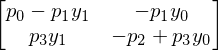

In [9]:
jac_x = sym.Matrix(ydot).jacobian(y)
jac_x

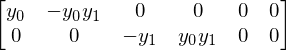

In [10]:
jac_p = sym.Matrix(ydot).jacobian(p)
jac_p

In [11]:
jac_x_f = sym.lambdify((y, p), jac_x)
jac_p_f = sym.lambdify((y, p), jac_p)

### Now we extend the ode sensitivity solver class above by passing the `Lambda` for Jacobians

In [12]:
class LotkaVolterraModel(OdeSolverForwardSens):
    
    def __init__(self, _rhs_f, _jac_x_f, _jac_p_f, n_states, n_params, times,
                 rtol=1e-5, atol=1e-6, y0=None):
        super(LotkaVolterraModel, self).__init__()
               
        if y0 is not None:
            self._y0 = np.array(y0, dtype=float) 
        self._rhs_f = _rhs_f
        self._jac_x_f = _jac_x_f
        self._jac_p_f = _jac_p_f
        
        self._n_states = n_states
        self._n_params = n_params
        self._times = times
        self._T = len(times)
        self._rtol = rtol
        self._atol = atol  

        
    def _rhs(self, y, t, p):
        return self._rhs_f(y, t, p)

    def _jac_x(self, y, p):
        return self._jac_x_f(y, p)

    def _jac_p(self, y, p):
        return self._jac_p_f(y, p)

### Initial values
 The list: `[0,1,6,13]` simply tells the solver the position of the state and sensitivity initial values, that needs to be estimated or fixed. Note that the state's initial values would be estimated.


In [14]:
times = np.arange(0, 21)
lv_ode_model = LotkaVolterraModel(rhs_f, jac_x_f, jac_p_f, 2, 6, times, 1e-6, 1e-5)
lv_ode_model.set_unknown_y0(2, [0,1,6,13])

## Custom ODE Op


In [15]:
class ODEGradop(theano.Op):
    def __init__(self, numpy_vjp):
        self._numpy_vjp = numpy_vjp

    def make_node(self, x, g):
        x = theano.tensor.as_tensor_variable(x)
        g = theano.tensor.as_tensor_variable(g)
        node = theano.Apply(self, [x, g], [g.type()])
        return node

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]

        g = inputs_storage[1]
        out = output_storage[0]
        out[0] = np.asarray(self._numpy_vjp(x, g))

        
class ODEop(theano.Op):

    def __init__(self, state, numpy_vjp):
        self._state = state
        self._numpy_vjp = numpy_vjp

    def make_node(self, x):
        x = theano.tensor.as_tensor_variable(x)

        return theano.Apply(self, [x], [x.type()])

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]
        out = output_storage[0]
        
        out[0] = np.asarray(self._state(x))    

    def grad(self, inputs, output_grads):
        x = inputs[0]
        g = output_grads[0]
        op = self

        grad_op = ODEGradop(self._numpy_vjp)   
        grad_op_apply = grad_op(x, g)
        
        return [grad_op_apply]

In [16]:
class solveCached(object):
    def __init__(self, ode_model):
      
        self._ode_model = ode_model    
        self._cachedParam = np.zeros(ode_model._n_params)
        self._cachedSens = np.zeros((ode_model._T, ode_model._n_states, ode_model._n_params))
        self._cachedState = np.zeros((ode_model._T,ode_model._n_states))
        
    def __call__(self, p):
        
        if np.all(p==self._cachedParam):
            state, sens = self._cachedState, self._cachedSens
            
        else:
            state, sens = self._ode_model.solve_with_sensitivities(p)
        
        return state, sens, self._ode_model._T, self._ode_model._n_states, self._ode_model._n_params

cached_solver=solveCached(lv_ode_model)

### The ODE state & VJP evaluation

Since we are essentially doing gradient $\times$ Sensitivity matrix product, we ocassionally call this VSP rather than VJP in some notebooks. Means the same.

In [17]:
def state(p):
    State, Sens, T, k, _ = cached_solver(np.array(p,dtype=np.float64))
    cached_solver._cachedState, cached_solver._cachedSens, cached_solver._cachedParam = State, Sens, p
    return State.reshape((k*T,))

def numpy_vsp(p, grad_output):    
    numpy_sens, T, k, d = cached_solver(np.array(p,dtype=np.float64))[1:]
    
    numpy_sens = numpy_sens.reshape((k*T,d))
    return numpy_sens.T.dot(grad_output)

## The  Hudson's Bay Company data



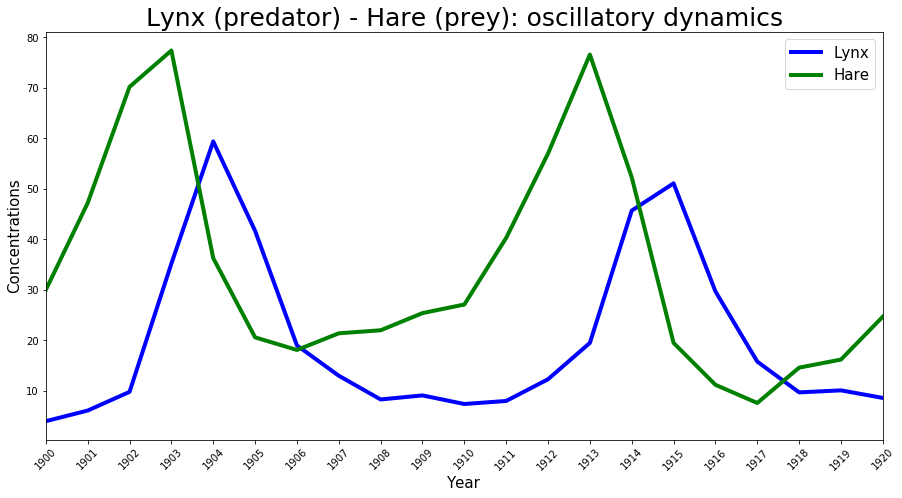

In [18]:
Year = np.arange(1900,1921,1)
Lynx = np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
                8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6])
Hare = np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4, 
                 27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])
plt.figure(figsize=(15, 7.5))
plt.plot(Year,Lynx,color='b', lw=4, label='Lynx')
plt.plot(Year,Hare,color='g', lw=4, label='Hare')
plt.legend(fontsize=15)
plt.xlim([1900,1920])
plt.xlabel('Year', fontsize=15)
plt.ylabel('Concentrations', fontsize=15)
plt.xticks(Year,rotation=45)
plt.title('Lynx (predator) - Hare (prey): oscillatory dynamics', fontsize=25);


## The probablistic model


In [ ]:
### Outputs hidden due to anonymity
import pymc3 as pm
from pymc3.variational.approximations import FullRank
theano.config.exception_verbosity= 'high'
theano.config.floatX = 'float64'
theano.config.compute_test_value = 'ignore'

# Define the data matrix
Y = np.vstack((Hare,Lynx)).T

# Now instantiate the theano custom ODE op
my_ODEop = ODEop(state,numpy_vsp)


# The probabilistic model
with pm.Model() as LV_model:

    # Priors for unknown model parameters
    alpha =  pm.Gamma('alpha', mu=0.5,sd=1)
    beta =  pm.Beta('beta', mu=0.1,sigma=0.1)
    gamma =  pm.Gamma('gamma', mu=0.5,sd=1)
    delta = pm.Beta('delta', mu=0.1,sigma=0.1)
    
    xt0 = pm.Lognormal('xto', mu=np.log(10), sd=1)
    yt0 = pm.Lognormal('yto', mu=np.log(10), sd=1)
    sigma = pm.HalfNormal('sigma', sd=1, shape=2)

    all_params = pm.math.stack([alpha,beta,gamma,delta,xt0,yt0],axis=0)
    ode_sol = my_ODEop(all_params)
    mu = ode_sol.reshape(Y.shape)
    

    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(mu), sd=sigma, observed=Y)
    
    advi=pm.FullRankADVI()
    tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval, std=advi.approx.std.eval ) 
    rho_approx = advi.approx.params[0] 
    mu_approx = advi.approx.params[1] 
    rho_approx.set_value(0.1*np.ones(rho_approx.eval().shape))     

    q_dist = advi.fit(5000,obj_n_mc=1,
                    obj_optimizer=pm.adam(learning_rate=0.01),callbacks=[tracker])  

In [ ]:
trace_vb = q_dist.sample(1000)
pm.plot_posterior(trace_vb)